# Active Learning on fruit images
We will try to use the same framework as for the numbers on the fruit images, see notebook 1  
Dataset: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition?resource=download

In [6]:
import os

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Import classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

In [10]:
# Show fruit subfolders
path = "ActiveLearning_ImageClassification/fruit/train"
fruits = os.listdir(path)
print(fruits)

['Apple Granny Smith', 'Banana', 'Pear', 'Strawberry', 'Tomato']


Apple Granny Smith, number of images: 492
Banana, number of images: 490
Pear, number of images: 696
Strawberry, number of images: 492
Tomato, number of images: 738


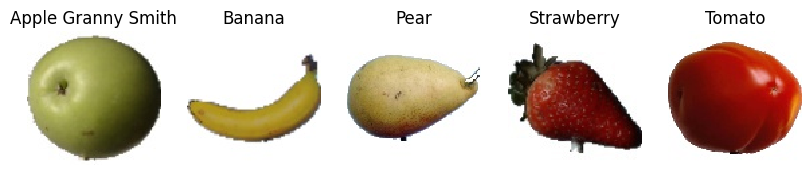

In [52]:
# Load image paths and show 5 examples of the fruits

examples_path = []
examples_images = []
subfolders = {}
for fruit in fruits:
    images = os.listdir(path + "/" + fruit)
    subfolders[fruit] = images
    print(fruit + ", number of images: " + str(len(images)))
    examples_path.append(path + "/" + fruit + "/" + images[0])
    examples_images.append(plt.imread(examples_path[-1]))

_, axes = plt.subplots(nrows=1, ncols=len(examples_path), figsize=(10, 3))
for ax, image, label in zip(axes, examples_images, fruits):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%s" % label)

In [49]:
# Create the training data
X = []
for fruit, images in subfolders.items():
    for image in images:
        X.append(plt.imread(path + "/" + fruit + "/" + image))
#test = [np.array([plt.imread(path + "/" + fruit + "/" + image)] for fruit, image in subfolders.items())]
print(len(X))
X = np.array(X)
# X = np.concatenate([np.array([plt.imread(path + "/" + fruit + "/" + image)] for fruit, image in subfolders.items())])
y = np.concatenate([np.array([fruit] * len(paths)) for fruit, paths in subfolders.items()])
print(y)

2908
['Apple Granny Smith' 'Apple Granny Smith' 'Apple Granny Smith' ...
 'Tomato' 'Tomato' 'Tomato']


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Source 
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

# COPIED OLD CODE BELOW

In [3]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

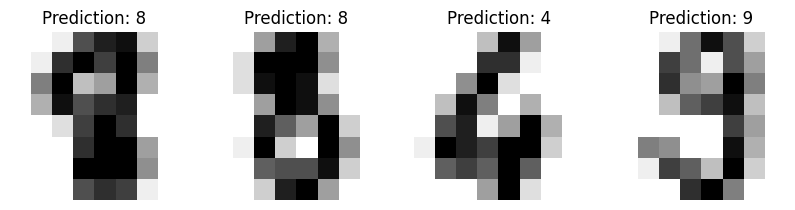

In [4]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

In [5]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


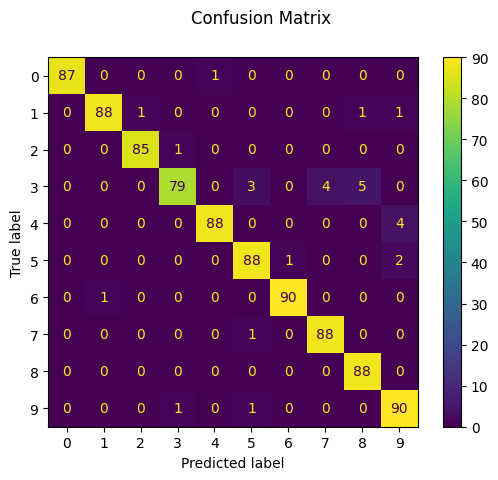

In [6]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Now we try to implement pool based active learning

In [7]:
# We use the first 10 instances as initial training data.
X_start = X_train[:10]
y_start = y_train[:10]
y_missing = np.full(shape=y_train.shape, fill_value=MISSING_LABEL)
y_missing[:10] = y_train[:10]

# Create a new classifier: a support vector classifier
clf_ac = SklearnClassifier(svm.SVC(probability=True, gamma=0.001),classes=np.unique(y_start), random_state=0)

# Learn the digits on the train subset
# clf_ac.fit(X_start, y_start)

# Predict the value of the digit on the test subset
# predicted_ac = clf_ac.predict(X_test)

In [8]:
qs = UncertaintySampling(method='entropy')

# Execute active learning cycle.
n_cycles = 200
for c in range(n_cycles):
    query_idx = qs.query(X=X_train, y=y_missing, clf=clf_ac)
    y_missing[query_idx] = y_train[query_idx]

# Fit final classifier.
clf_ac.fit(X_train[~np.isnan(y_missing)], y_missing[~np.isnan(y_missing)])

# Predict the value of the digit on the test subset
predicted_ac = clf_ac.predict(X_test)

In [9]:
print(len(y_missing))
print(len(y_missing[~np.isnan(y_missing)]))

898
210


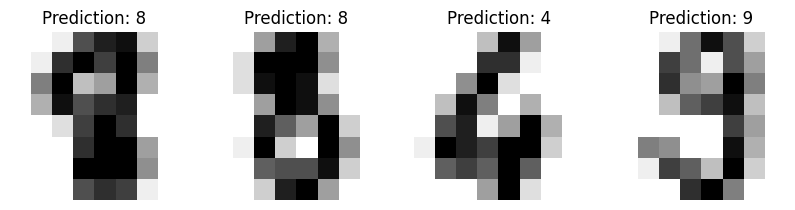

In [10]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted_ac):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

In [11]:
print(
    f"Classification report for classifier {clf_ac}:\n"
    f"{metrics.classification_report(y_test, predicted_ac)}\n"
)

Classification report for classifier SklearnClassifier(classes=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                  estimator=SVC(gamma=0.001, probability=True), random_state=0):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        88
           1       0.97      0.97      0.97        91
           2       0.99      0.98      0.98        86
           3       0.99      0.82      0.90        91
           4       0.99      0.91      0.95        92
           5       0.93      0.95      0.94        91
           6       0.96      0.99      0.97        91
           7       0.96      1.00      0.98        89
           8       0.94      0.95      0.95        88
           9       0.82      0.98      0.89        92

    accuracy                           0.95       899
   macro avg       0.95      0.95      0.95       899
weighted avg       0.95      0.95      0.95       899




Confusion matrix:
[[84  0  0  0  1  0  3  0  0  0]
 [ 0 88  0  0  0  1  0  0  1  1]
 [ 0  0 84  1  0  0  0  0  0  1]
 [ 0  0  1 75  0  3  0  4  3  5]
 [ 0  0  0  0 84  0  0  0  0  8]
 [ 0  0  0  0  0 86  1  0  0  4]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  0  0 89  0  0]
 [ 0  2  0  0  0  1  0  0 84  1]
 [ 0  0  0  0  0  1  0  0  1 90]]


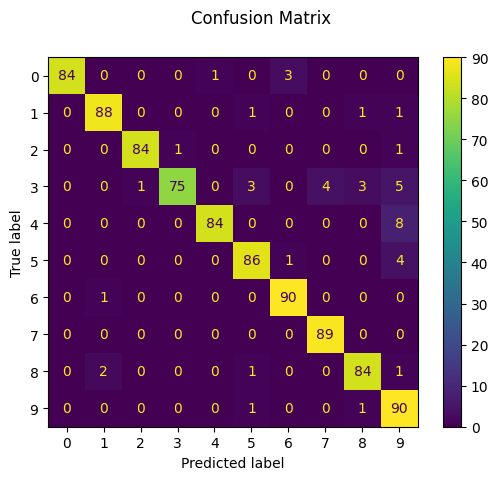

In [12]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_ac)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()